# Get 6C Data for Event

Get 6C data for ROMY and store it

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client

from andbro__read_sds import __read_sds

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [40]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"romy_events/figures/"

config['path_to_outdata'] = data_path+"romy_events/data/"

config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_inventory'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless/"

## BSPF coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941

config['submask'] = ""


config['seed_acc'] = "BW.DROMY..HH*"
config['seed_acc'] = "GR.FUR..HH*"


config['path_to_rot'] = archive_path+"romy_archive/"

if "DROMY" in config['seed_acc']:
    config['path_to_acc'] = archive_path+"romy_archive/"
elif "FUR" in config['seed_acc']:
    config['path_to_acc'] = bay_path+"mseed_online/archive/"

## Eventtime
config['eventtime'] = obs.UTCDateTime("2023-10-25 13:40:00")

# config['event_name'] = "Italy"
# config['tbeg'] = obs.UTCDateTime("2023-10-25 13:45:00")
# config['tend'] = obs.UTCDateTime("2023-10-25 13:50:00")

config['event_name'] = "Morocco"
config['tbeg'] = obs.UTCDateTime("2023-09-08 22:00")
config['tend'] = obs.UTCDateTime("2023-09-08 23:00")

# config['event_name'] = "Morocco2"
# config['tbeg'] = obs.UTCDateTime("2023-09-08 22:30")
# config['tend'] = obs.UTCDateTime("2023-09-08 23:30")

# config['event_name'] = "Mindanao" ## M7-6
# config['tbeg'] = obs.UTCDateTime("2023-12-02 14:37")
# config['tend'] = obs.UTCDateTime("2023-12-02 17:00")

# config['event_name'] = "Mindanao2" ## M6.6
# config['tbeg'] = obs.UTCDateTime("2023-12-03 10:35")
# config['tend'] = obs.UTCDateTime("2023-12-03 12:35")

# config['event_name'] = "Meteoride"
# config['tbeg'] = obs.UTCDateTime("2024-01-21 00:15")
# config['tend'] = obs.UTCDateTime("2024-01-21 00:50")

config['event_name'] = "Montenegro"
config['tbeg'] = obs.UTCDateTime("2024-03-14 03:06")
config['tend'] = obs.UTCDateTime("2024-03-14 03:36")


config['fmin'] = 0.01
config['fmax'] = 10

In [41]:
def __rotate_romy_ZUV_ZNE(st, inv):

    from obspy.signal.rotate import rotate2zne

    ori_z = inv.get_orientation("BW.ROMY.10.BJZ")
    ori_u = inv.get_orientation("BW.ROMY..BJU")
    ori_v = inv.get_orientation("BW.ROMY..BJV")

    romy_z = st.select(channel="*Z")[0].data
    romy_u = st.select(channel="*U")[0].data
    romy_v = st.select(channel="*V")[0].data


    romy_z, romy_n, romy_e =rotate2zne(
                                       romy_z, ori_z['azimuth'], ori_z['dip'],
                                       romy_u, ori_u['azimuth'], ori_u['dip'],
                                       romy_v, ori_v['azimuth'], ori_v['dip'],
                                       inverse=False
                                      )

    st_new = st.copy()

    st_new.select(channel="*Z")[0].data = romy_z
    st_new.select(channel="*U")[0].data = romy_n
    st_new.select(channel="*V")[0].data = romy_e

    ch = st_new.select(channel="*U")[0].stats.channel[:2]

    st_new.select(channel="*U")[0].stats.channel = f"{ch}N"
    st_new.select(channel="*V")[0].stats.channel = f"{ch}E"

    return st_new

## Load Data

#### Find event in catalog

In [42]:
event = Client("IRIS").get_events(starttime=config['tbeg'], endtime=config['tend'], minmagnitude=4.0)
event = event[0]

#### Load inventory

In [43]:
romy_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")

if "DROMY" in config['seed_acc']:
    seis_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_DROMY")
elif "FUR" in config['seed_acc']:
    seis_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.GR_FUR")


In [50]:
st0 = obs.Stream()

st0 += __read_sds(config['path_to_sds'], "BW.ROMY.10.BJZ", config['tbeg']-1, config['tend']+1)
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJU", config['tbeg']-1, config['tend']+1)
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJV", config['tbeg']-1, config['tend']+1)

if len(st0) > 3:
    print(f" -> merging required!")
    st0.merge(fill_value="interpolate")

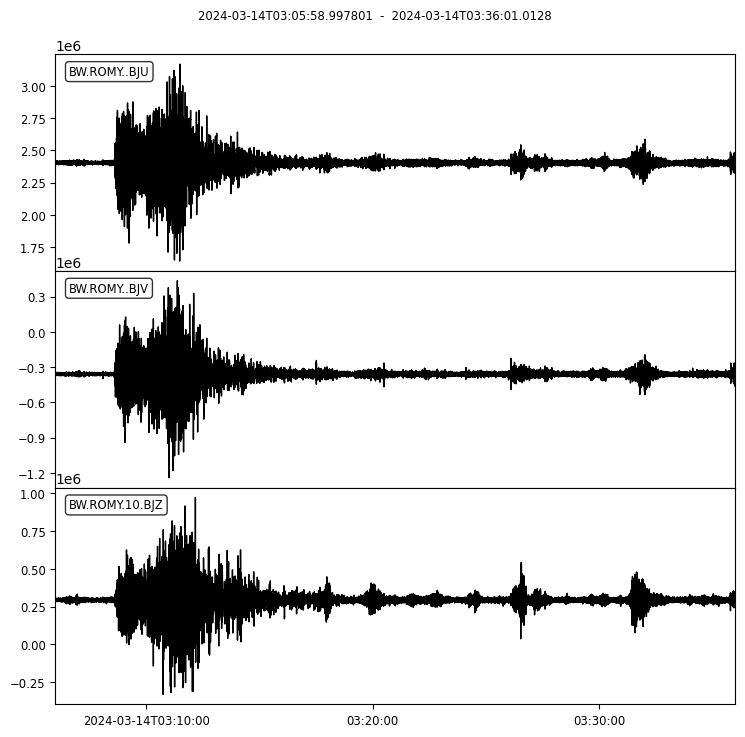

In [45]:
st0.plot(equal_scale=False);

## Process Translation Data

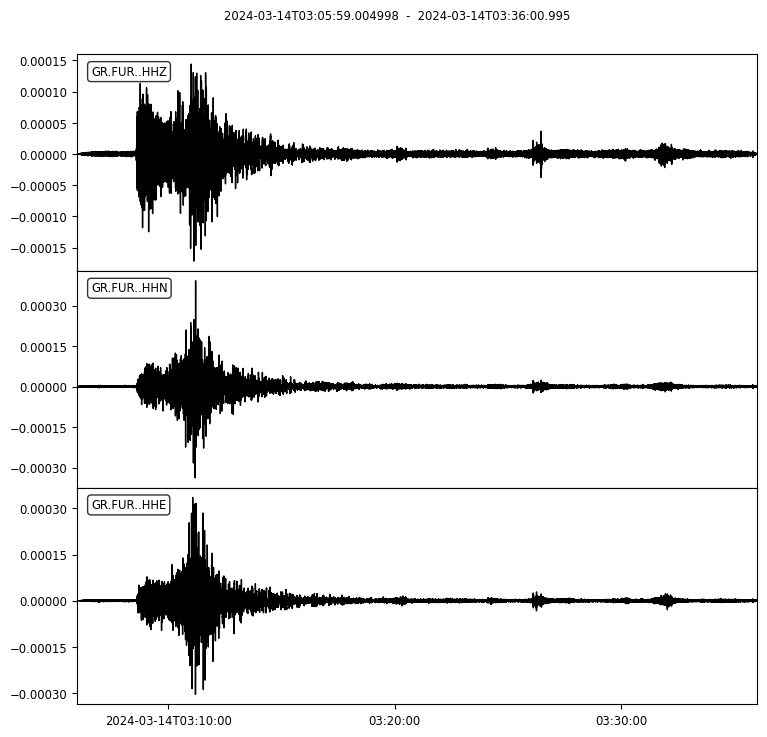

In [46]:
acc = __read_sds(config['path_to_acc'], config['seed_acc'], config['tbeg']-1, config['tend']+1)

acc = acc.remove_response(seis_inv, output="ACC")

acc = acc.detrend("demean")

acc.plot(equal_scale=False);

## Process Rotation Data

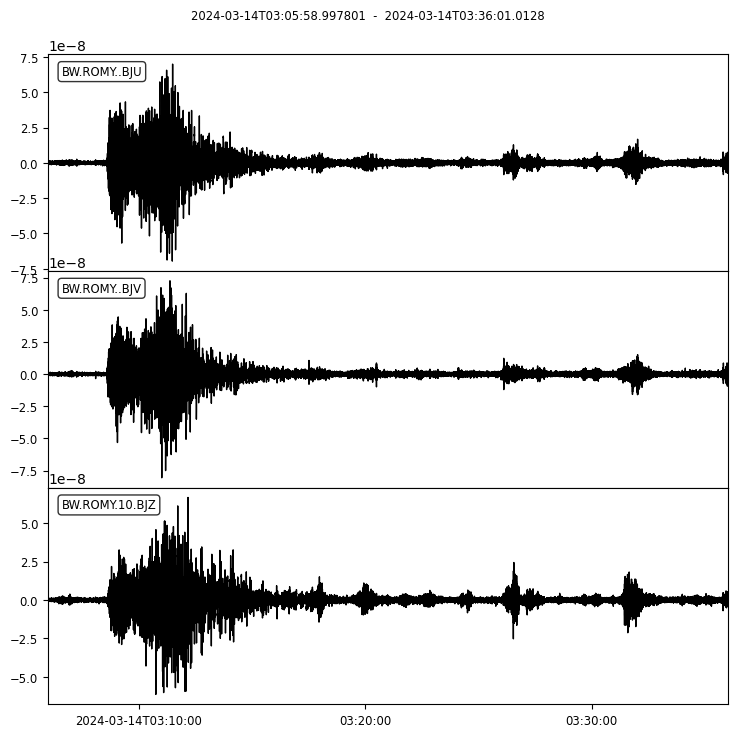

In [47]:
rot = st0.copy()

rot = rot.remove_sensitivity(romy_inv)

rot = rot.detrend("demean")
# rot = rot.taper(0.1)
# rot = rot.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

rot.plot(equal_scale=False);

In [48]:
rot_zne = __rotate_romy_ZUV_ZNE(rot, romy_inv)

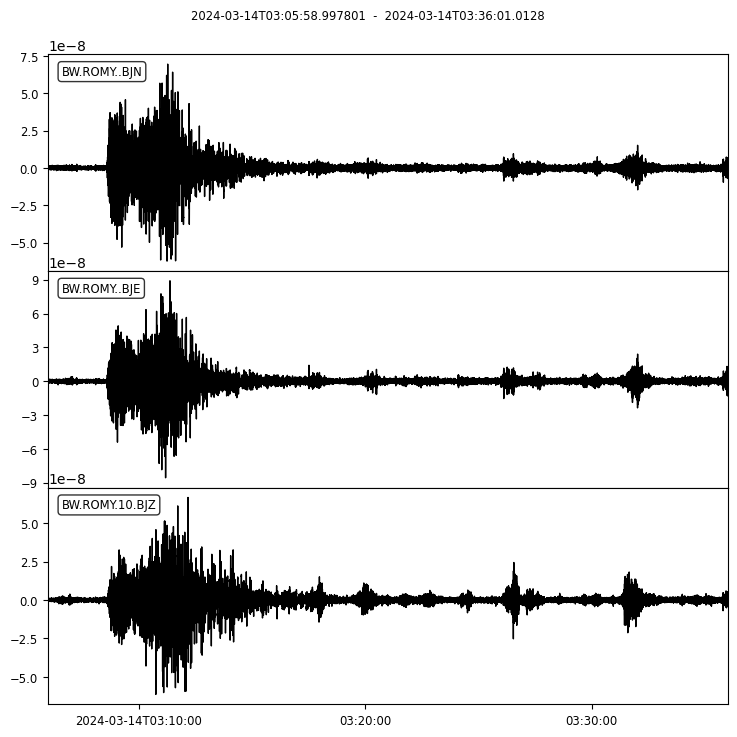

In [49]:
rot_zne.plot(equal_scale=False);

## Compare Waveforms

In [51]:
def __makeplot_waveform_comparison(st1, st2):

    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

    font = 14

    rot_scaling = 1e9

    lw = 1

    ax[0].plot(st1.select(channel="*Z")[0].times(), st1.select(channel="*Z")[0].data*rot_scaling, lw=lw, label="Z", color="darkred", ls="-", zorder=3)
    ax[0].plot(st2.select(channel="*Z")[0].times(), st2.select(channel="*Z")[0].data*rot_scaling, lw=lw, label="Z", color="black", zorder=2)

    ax[1].plot(st1.select(channel="*U")[0].times(), st1.select(channel="*U")[0].data*rot_scaling, lw=lw, label="U", color="darkred", ls="-", zorder=3)
    ax[1].plot(st2.select(channel="*N")[0].times(), st2.select(channel="*N")[0].data*rot_scaling, lw=lw, label="N", color="black", zorder=2)

    ax[2].plot(st1.select(channel="*V")[0].times(), st1.select(channel="*V")[0].data*rot_scaling, lw=lw, label="V", color="darkred", ls="-", zorder=3)
    ax[2].plot(st2.select(channel="*E")[0].times(), st2.select(channel="*E")[0].data*rot_scaling, lw=lw, label="E", color="black", zorder=2)

    ax00 = ax[0].twinx()
    diff_Z = ( abs(st1.select(channel="*Z")[0].data - st2.select(channel="*Z")[0].data)*rot_scaling )
    ax00.fill_between(st2.select(channel="*Z")[0].times(), diff_Z, color="grey", alpha=0.5, zorder=1)
    ax00.set_ylim(-1, 10)
    ax00.set_ylabel("Z - Z (nrad/s)", color="darkgrey")

    ax11 = ax[1].twinx()
    diff_N = ( abs(st1.select(channel="*U")[0].data - st2.select(channel="*N")[0].data)*rot_scaling )
    ax11.fill_between(st2.select(channel="*N")[0].times(), diff_N, color="grey", alpha=0.5, zorder=1)
    ax11.set_ylim(-1, 10)
    ax11.set_ylabel("U - N (nrad/s)", color="darkgrey")

    ax22 = ax[2].twinx()
    diff_E = ( abs(st1.select(channel="*V")[0].data - st2.select(channel="*E")[0].data)*rot_scaling )
    ax22.fill_between(st2.select(channel="*E")[0].times(), diff_E, color="grey", alpha=0.5, zorder=1)
    ax22.set_ylim(-1, 10)
    ax22.set_ylabel("V - E (nrad/s)", color="darkgrey")

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        # ax[i].set_xscale("log")
        ax[i].set_ylabel(r"$\Omega$ (nrad/s)")

    ax[2].set_xlabel("Time (s)")
    ax[0].set_title(f"{config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC | {config['fmin']}-{config['fmax']} Hz ")

    plt.show();
    return fig

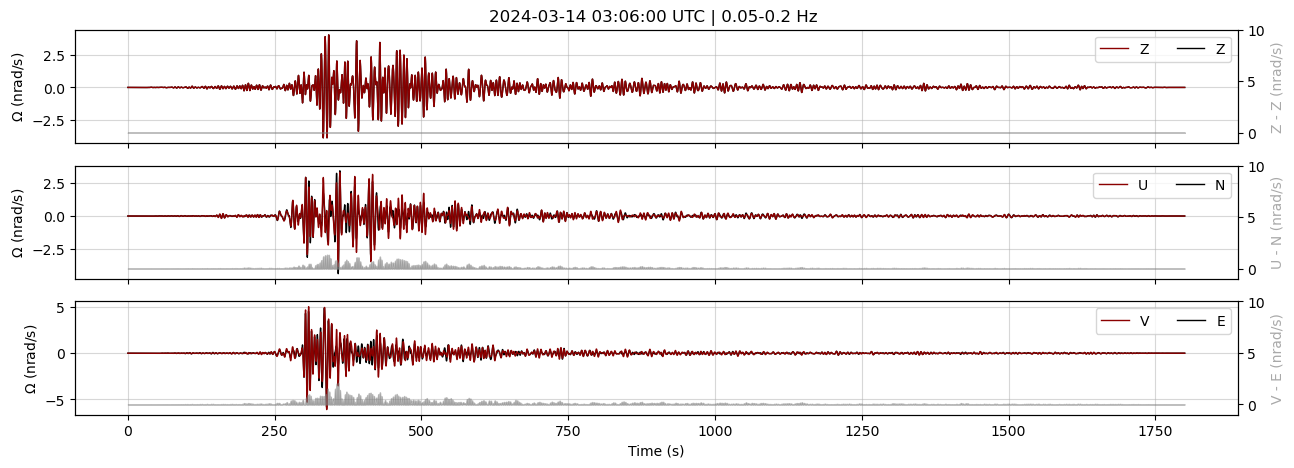

In [52]:
config['fmin'] = 0.05
config['fmax'] = 0.2

st_cp = rot.copy()
st_cp = st_cp.detrend("demean");
st_cp = st_cp.taper(0.1);
st_cp = st_cp.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);
st_cp.trim(config['tbeg'], config['tend'])

st_rot_cp = rot_zne.copy()
st_rot_cp = st_rot_cp.detrend("demean");
st_rot_cp = st_rot_cp.taper(0.1);
st_rot_cp = st_rot_cp.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

st_rot_cp.trim(config['tbeg'], config['tend'])



fig = __makeplot_waveform_comparison(st_cp, st_rot_cp)

fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_waveforms.png", format="png", dpi=200, bbox_inches='tight');


In [53]:
def __makeplot_spectra_comparison(st1, st2):

    def __multitaper_psd(arr, dt, n_win=5, time_bandwidth=4.0):

        import multitaper as mt

        out_psd = mt.MTSpec(arr, nw=time_bandwidth, kspec=n_win, dt=dt, iadapt=0)

        _f, _psd = out_psd.rspec()

        f = _f.reshape(_f.size)
        psd = _psd.reshape(_psd.size)

        ## 95% confidence interval
        # _psd95 = out_psd.jackspec()
        # psd95_lower, psd95_upper = psd95[::2, 0], psd95[::2, 1]

        return f, psd

    Tsec = 5
    f1_Z, psd1_Z = __multitaper_psd(st1.select(channel="*Z")[0].data, st1[0].stats.delta ,n_win=Tsec)
    f2_Z, psd2_Z = __multitaper_psd(st2.select(channel="*Z")[0].data, st2[0].stats.delta ,n_win=Tsec)

    f1_U, psd1_U = __multitaper_psd(st1.select(channel="*U")[0].data, st1[0].stats.delta ,n_win=Tsec)
    f2_N, psd2_N = __multitaper_psd(st2.select(channel="*N")[0].data, st2[0].stats.delta ,n_win=Tsec)

    f1_V, psd1_V = __multitaper_psd(st1.select(channel="*V")[0].data, st1[0].stats.delta ,n_win=Tsec)
    f2_E, psd2_E = __multitaper_psd(st2.select(channel="*E")[0].data, st2[0].stats.delta ,n_win=Tsec)


    fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

    font = 14

    rot_scaling = 1e9

    lw = 1

    ax[0].plot(f1_Z, psd1_Z, lw=lw, label="Z", color="darkred", ls="-", zorder=3)
    ax[0].plot(f2_Z, psd2_Z, lw=lw, label="Z", color="black", zorder=2)

    ax[1].plot(f1_U, psd1_U, lw=lw, label="U", color="darkred", ls="-", zorder=3)
    ax[1].plot(f2_N, psd2_N, lw=lw, label="N", color="black", zorder=2)

    ax[2].plot(f1_V, psd1_V, lw=lw, label="V", color="darkred", ls="-", zorder=3)
    ax[2].plot(f2_E, psd2_E, lw=lw, label="E", color="black", zorder=2)


    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].set_xscale("log")
        # ax[i].set_yscale("log")
        ax[i].grid(which="both", alpha=0.5)
        ax[i].set_ylabel(r"PSD (rad$^2$/s$^2$/Hz)")
        ax[i].set_xlim(2e-2, 2e-1)

    ax[2].set_xlabel("Frequency (Hz)")
    ax[0].set_title(f"{config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC | {config['fmin']}-{config['fmax']} Hz ")

    plt.show();
    return fig

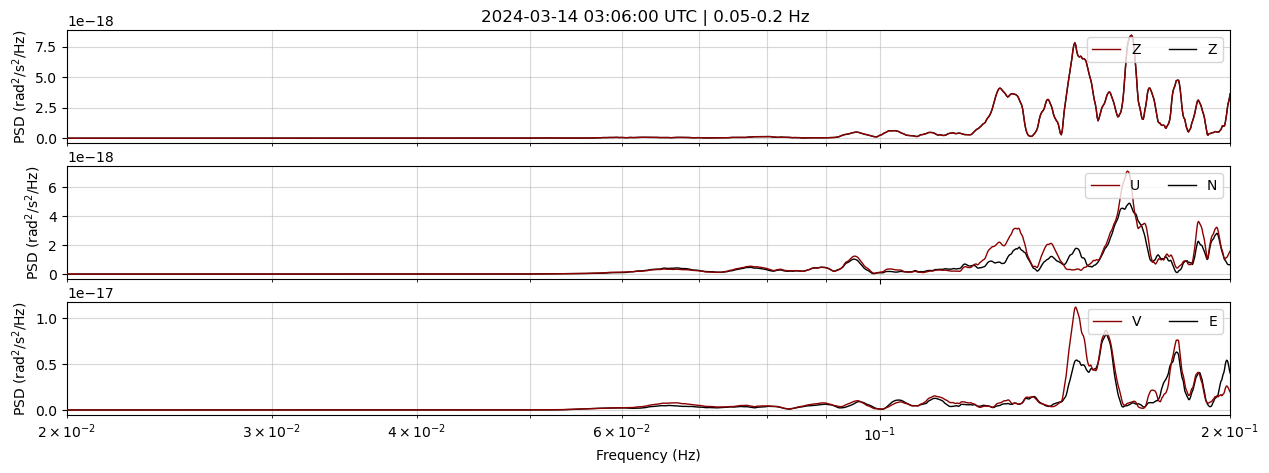

In [54]:
fig = __makeplot_spectra_comparison(st_cp, st_rot_cp)

## Write Data

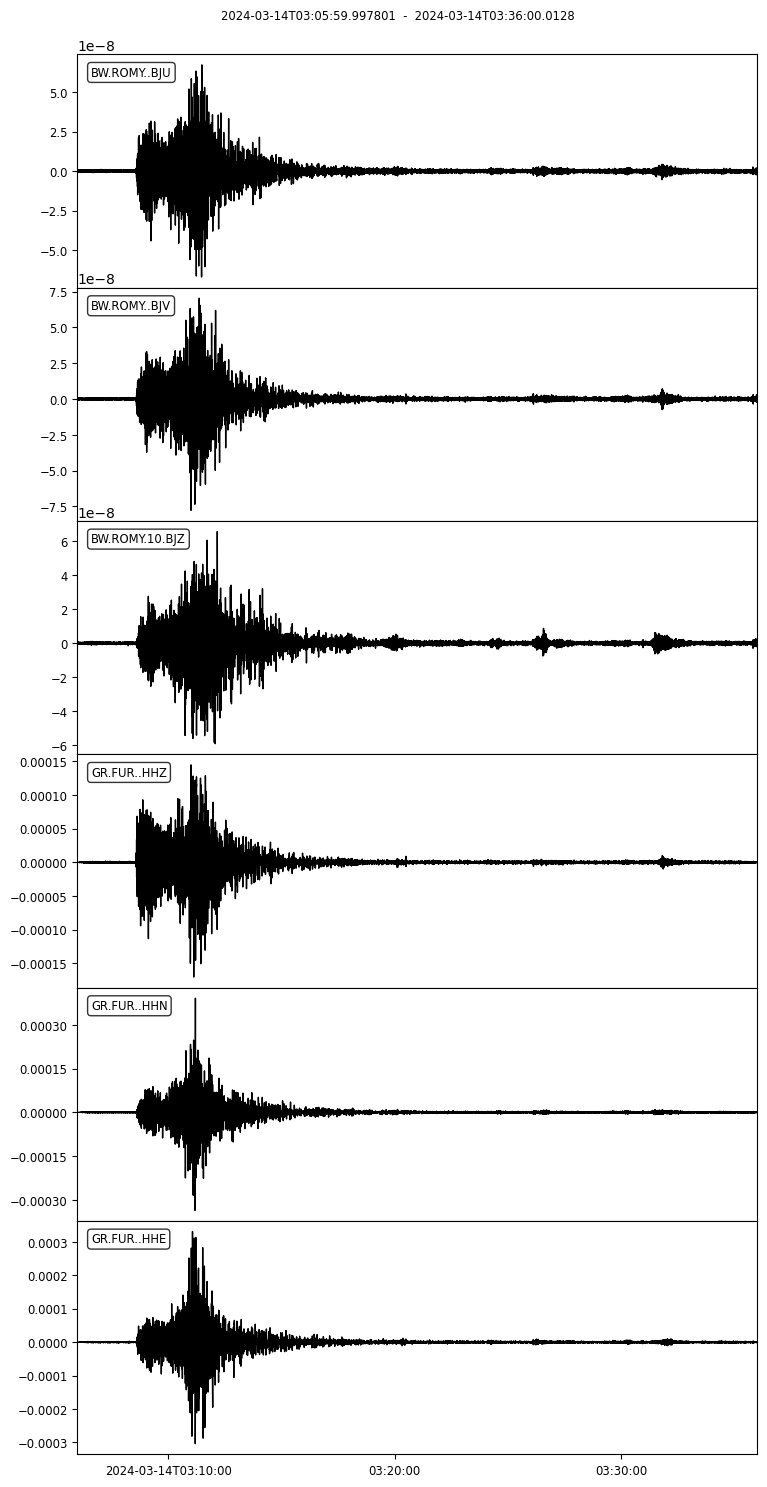

-> store:  /home/andbro/kilauea-data/romy_events/data/ROMY_Montenegro_20240314_6C.mseed


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [59]:
st_all = rot.copy();
st_all += acc.copy();

st_all = st_all.resample(20, no_filter=False)

st_all = st_all.trim(config['tbeg'], config['tend'])

st_all.plot(equal_scale=False);

# filename = f"ROMY_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_{str(config['tbeg'].time).split('.')[0]}_6C.mseed"
filename = f"ROMY_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_6C.mseed"
print(f"-> store: ", config['path_to_outdata']+filename)
st_all.write(config['path_to_outdata']+filename, format="MSEED");


In [56]:
# test = st_all.copy()
# # test.trim(config['tbeg']+22*60, config['tend']-17*60)
# test.detrend("linear")
# test.taper(0.01)
# test.filter("bandpass", freqmin=0.01, freqmax=0.1, corners=4, zerophase=True)
# test.plot(equal_scale=False);